# knn approach to finding traces with flipped polarity in seismic data

We use ML to classify the polarity $(\pm 1)$ of seismic traces. Each trace corresponds to a hydrophone which listens for sound wave reflecting from the geology in the subsurface of the Earth. The sound waves have "shots" as their sources. These shots are denotations set off above the ground.

Sometimes the channel arrays have geophones which are recording data with a phase inversion of -1. That is, they record -f(t) when they should be recording f(t). To process seismic data into a tomographic image, these flipped polarity traces need to be identified.

This open source seismic data comes with channels that have this error. We use a nearest-neighbors algorithm to catalog them.

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [25]:
df= pd.read_csv('seismic_traces.txt',header=None,skiprows=[0])

The data is being read as series:

In [26]:
print df.shape

(5391360, 1)


But each datapoint is made up of 51 attributes and a target label $(\pm 1)$, so we need to reorganize:

In [27]:
df.head(10)

,0
0,channel=1 shot=2372 label=-1
1,0 1.35109469e-01
2,1 -1.49369106e-01
3,2 1.57715330e+01
4,3 1.42361059e+01
5,4 -3.59257355e+01
6,5 2.69094620e+01
7,6 -1.50129881e+01
8,7 1.72546041e+00
9,8 7.09569931e+00


In [28]:
df2 = pd.DataFrame(index=range(0,53))

for x in range(int(len(df)/2)): #for production len(df), or len(df)/2
    if x % 52 == 0:
        df2[x] = pd.Series(df.iloc[x:x+53,0].reset_index()[0])


In [29]:
def breakString(x):
    ls = x.split()
    return ls[len(ls)-1]

def pickSign(str):      # function to pick send gut=-1 to -1, gut=1 to 1
    if str[-2:-1]=='-':
        return -1
    else:
        return 1

In [30]:
df2.head()

,0,52,104,156,208,260,312,364,416,468,...,2695160,2695212,2695264,2695316,2695368,2695420,2695472,2695524,2695576,2695628
0,channel=1 shot=2372 label=-1,channel=9 shot=2372 label=1,channel=17 shot=2372 label=1,channel=25 shot=2372 label=1,channel=33 shot=2372 label=1,channel=41 shot=2372 label=-1,channel=49 shot=2372 label=1,channel=57 shot=2372 label=1,channel=65 shot=2372 label=1,channel=73 shot=2372 label=1,...,channel=2225 shot=6668 label=1,channel=2233 shot=6668 label=1,channel=2241 shot=6668 label=-1,channel=2249 shot=6668 label=1,channel=2257 shot=6668 label=1,channel=2265 shot=6668 label=1,channel=2273 shot=6668 label=1,channel=2281 shot=6668 label=-1,channel=2289 shot=6668 label=1,channel=2297 shot=6668 label=1
1,0 1.35109469e-01,0 1.45933300e-01,0 -6.92833722e-01,0 -5.48514366e-01,0 -5.12570068e-02,0 -8.86980057e-01,0 -1.76063627e-01,0 2.22643271e-01,0 1.17118979e+00,0 5.71239889e-01,...,0 -5.05644798e+01,0 -5.35335121e+01,0 5.16573334e+01,0 -6.36245384e+01,0 -6.22858963e+01,0 -6.69708176e+01,0 -6.17421837e+01,0 4.24557686e+01,0 -3.49117241e+01,0 -3.27148094e+01
2,1 -1.49369106e-01,1 1.75313914e+00,1 1.99631679e+00,1 3.04945016e+00,1 2.88342237e+00,1 -1.33383894e+00,1 1.71477425e+00,1 1.66236949e+00,1 2.14069176e+00,1 1.45541644e+00,...,1 -2.43941898e+01,1 -2.50681992e+01,1 1.98644161e+01,1 -2.24622288e+01,1 -1.41626024e+01,1 -1.40747652e+01,1 -7.30249357e+00,1 1.30712271e+01,1 -8.87607956e+00,1 -1.96998653e+01
3,2 1.57715330e+01,2 -1.49585085e+01,2 -2.35901699e+01,2 -2.49880772e+01,2 -3.32448540e+01,2 2.98935757e+01,2 -3.22538071e+01,2 -2.51346836e+01,2 -1.51347399e+01,2 -5.07944202e+00,...,2 -2.13396549e+01,2 -1.86809387e+01,2 2.29194832e+01,2 -1.65655098e+01,2 -2.28135605e+01,2 -2.79594479e+01,2 -2.25943642e+01,2 3.03915577e+01,2 -2.37743130e+01,2 -2.82103367e+01
4,3 1.42361059e+01,3 -1.81383457e+01,3 -1.35441465e+01,3 -7.66792870e+00,3 -1.11441040e+01,3 1.45502367e+01,3 -1.61157742e+01,3 -1.30265388e+01,3 -2.11821022e+01,3 -3.24019890e+01,...,3 -1.31772375e+01,3 -7.91394949e+00,3 2.81915817e+01,3 -2.24558468e+01,3 -3.33276749e+01,3 -3.37345467e+01,3 -2.52948914e+01,3 2.34377728e+01,3 -1.42750978e+01,3 -7.85312891e+00


In [31]:
df3 = df2.applymap(breakString).transpose()
df3['Polarity']= df3[0].apply(pickSign)

#We have the target column now, so we can drop the gut=+/-1 column.
#Write out dataframe

df4 = df3.drop(labels=[0,52],axis=1)

**Now we have the data in the shape that we want. Every row corresponds to a data point, with the entries being the samples of the recorded sound waves.**

In [32]:
df4.head(6)

,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,Polarity
0,1.35109469e-01,-1.49369106e-01,1.57715330e+01,1.42361059e+01,-3.59257355e+01,2.69094620e+01,-1.50129881e+01,1.72546041e+00,7.09569931e+00,1.46335602e+00,...,3.21032262e+00,-6.10652637e+00,-6.63434744e+00,7.87241983e+00,6.82086897e+00,-4.39545631e+00,7.42289352e+00,1.75441399e+01,3.22355962e+00,-1
52,1.45933300e-01,1.75313914e+00,-1.49585085e+01,-1.81383457e+01,2.48362637e+01,-1.77127659e+00,6.10797930e+00,6.50432706e-01,1.24292898e+01,-2.07663879e+01,...,-6.89559555e+00,-2.26281190e+00,8.67931843e-01,6.58300161e+00,-2.52325439e+00,1.95214581e+00,-1.05873799e+00,6.87787950e-01,5.56250906e+00,1
104,-6.92833722e-01,1.99631679e+00,-2.35901699e+01,-1.35441465e+01,1.63886700e+01,-2.81123400e+00,2.92025834e-01,1.99671593e+01,1.88208694e+01,-1.40622349e+01,...,5.06641245e+00,-4.83957577e+00,-7.73365974e+00,3.41644979e+00,-2.48874712e+00,-6.23853803e-01,-5.78418303e+00,-1.94017529e+00,3.14864397e+00,1
156,-5.48514366e-01,3.04945016e+00,-2.49880772e+01,-7.66792870e+00,1.78881626e+01,-1.10457926e+01,9.76121712e+00,1.14444103e+01,4.48660088e+00,-8.39676380e+00,...,8.91458607e+00,4.63351870e+00,-4.62167472e-01,-4.35263920e+00,-6.80716562e+00,4.04786921e+00,5.90873194e+00,-9.53969765e+00,-5.92452812e+00,1
208,-5.12570068e-02,2.88342237e+00,-3.32448540e+01,-1.11441040e+01,1.66472816e+01,-1.51332645e+01,2.12284908e+01,4.14150047e+00,1.19304018e+01,-1.90980256e+00,...,5.17904234e+00,-3.36299109e+00,6.31671906e+00,8.00372982e+00,-8.22849369e+00,-1.98929179e+00,1.32404604e+01,7.56298685e+00,-2.87491727e+00,1
260,-8.86980057e-01,-1.33383894e+00,2.98935757e+01,1.45502367e+01,-1.49652586e+01,8.31736684e-01,-2.71597271e+01,-5.63089657e+00,1.96172218e+01,1.47149630e+01,...,6.80858278e+00,2.86596417e+00,5.52099371e+00,5.21112633e+00,-1.25897455e+01,1.14112198e+00,-3.04135036e+00,6.11574554e+00,-1.16966801e+01,-1


In [25]:
# To write out the above dataframe to have it stored after the flow of modifications, use:
# df4.to_csv('parallel_traces.csv',index=False)

### Building the nearest-neighbors model
We proceed to split the data for training/testing and build the model.

In [35]:
X = df4.drop(labels='Polarity',axis=1)
y = df4['Polarity']*-1
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

We test to find the optimal k, the number of neighbors, via cross validation using cross_val_score. Since this is a classification problem, we test for accuracy.

In [284]:
cv_scores = []
for n in range(3,14,2):
    knn = KNeighborsClassifier(n_neighbors=n,weights='uniform')
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())


 Accuracies are  [0.9209877728692245, 0.908101838003685, 0.8970936339329674, 0.8903549739133221, 0.8852880981466527, 0.8806327317823397]

 Optimal k = 3


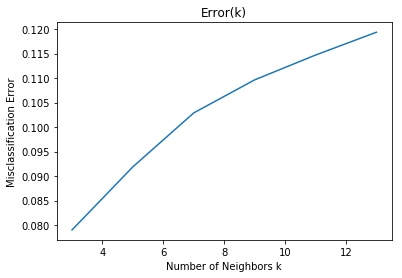

In [299]:
# Let's plot the misclassification error, call it msc
msc = [1 - x for x in cv_scores]
print '\n Accuracies are ', cv_scores

n_vals = (list(range(3,14,2)))
optimalMSC = n_vals[msc.index(min(msc))]
print '\n Optimal k =', optimalMSC

plt.plot(n_vals, msc)

plt.title('Error(k)')
plt.xlabel("Number of Neighbors k")
plt.ylabel("Misclassification Error")
plt.show()



In [67]:
nrnb7 = KNeighborsClassifier(n_neighbors=7,weights='uniform').fit(X_train, y_train)
print 'Score for k = 7 knn-model', nrnb7.score(X_test,y_test)

Score for k = 7 knn-model 0.9033179012345679


In [66]:
nrnb3 = KNeighborsClassifier(n_neighbors=3, weights='uniform').fit(X_train,y_train)
print 'Score for k = 3 knn-model', nrnb3.score(X_test,y_test)

 Score for k = 3 knn-model 0.9274691358024691


In [302]:
y_test_reset = y_test.reset_index()
print(y_test_reset.iloc[60:80])

      index  Polarity
60   829192        -1
61   458952        -1
62  1229228        -1
63  1735604        -1
64  1733940         1
65     4628        -1
66  2101684        -1
67  1087840        -1
68   143156        -1
69   914992        -1
70   513136        -1
71  1703520        -1
72  1923896        -1
73  1879488        -1
74    85540         1
75  1449604        -1
76  2155972        -1
77   191672         1
78  1965548        -1
79   214552        -1


In [68]:
# to predict, change value of n to check different cases:
n = 23
tstPoint = X_test.iloc[n].values.reshape(1,-1)
print 'test value target ', y_test.iloc[n]
tstPoint_kn = nrnb3.kneighbors(tstPoint)


print 'nearest neighbors: '
print y_train.iloc[tstPoint_kn[1][0]]

test value target  -1
nearest neighbors: 
2019368   -1
2019420   -1
2019472   -1
Name: Polarity, dtype: int64


### Can we improve the model via some l2-scaling in preprocessing?

Answer: yes, but minimally so.

In [70]:
transformer = Normalizer(norm='l2').fit(X_train)  
X_train_scaled = transformer51.transform(X_train)
X_test_scaled = transformer51.transform(X_test)

In [71]:
nrnb3_scaled  = KNeighborsClassifier(n_neighbors=3, weights='uniform').fit(X_train_scaled,y_train)
print 'Using l2-normalization on each observation gives an accuracy of the k = 3 model of', nrnb3_scaled.score(X_test_scaled,y_test)

Using l2-normalization on each observation gives an accuracy of the k = 3 model of 0.9341820987654321


### Can we use only two attributes?

The answer is, it depends. For example, we will see that if we use X[[10,20]] then we don't even beat the most-frequent dummy classfier. Then we will see that if choose X[[1,2]] for our attributes, we get a much improved accuracy but still lag behind the 51-dimensional model. 

In [318]:
X2d_train,X2d_test,y2d_train,y2d_test = train_test_split(X[[10,20]],y,random_state=0)

In [323]:
cv_scores_2d = []
for n in range(3,50,2):
    knn = KNeighborsClassifier(n_neighbors=n,weights='uniform')
    scores = cross_val_score(knn, X2d_train, y2d_train, cv=5, scoring='accuracy')
    cv_scores_2d.append(scores.mean())


 2d case: optimal k = 39


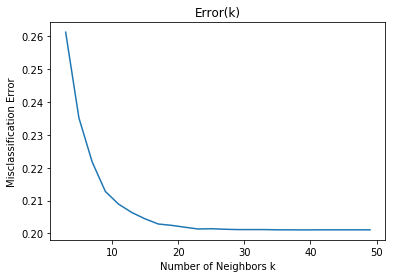

In [326]:
# Let's plot the misclassification error, call it msc
msc_2d = [1 - x for x in cv_scores_2d]

n_vals_2d = (list(range(3,50,2)))
optimalMSC_2d = n_vals_2d[msc_2d.index(min(msc_2d))]
print '\n 2d case: optimal k =', optimalMSC_2d

plt.plot(n_vals_2d, msc_2d)

plt.title('Error(k)')
plt.xlabel("Number of Neighbors k")
plt.ylabel("Misclassification Error")
plt.show()

In [361]:
#Seems ok to stop at k = 30:
nrnb_2d = KNeighborsClassifier(n_neighbors=30, weights='uniform').fit(X2d_train,y2d_train)

In [364]:
print 'nrnb_2d has accuracy of ',  nrnb_2d.score(X2d_test,y2d_test)

nrnb_2d has accuracy of  0.7976851851851852


How does it compare to the dummy classifier?

In [367]:
from sklearn.dummy import DummyClassifier

mostFreq_clsf = DummyClassifier(strategy='most_frequent').fit(X2d_train,y2d_train)
uniform_clsf = DummyClassifier(strategy='uniform').fit(X2d_train,y2d_train)

In [369]:
print 'Dummy most-frequent classifier has accuracy =', mostFreq_clsf.score(X2d_test,y2d_test)
print 'Dummy uniform classifier has accuracy =', uniform_clsf.score(X2d_test,y2d_test)

Dummy most-frequent classifier has accuracy = 0.7977623456790124
Dummy uniform classifier has accuracy = 0.4925925925925926


__Using two attributes only does not seem to be useful since we do not beat the most-frequent classifier.__

How about if we try using the first two attributes as opposed to the 10,20 ones?

In [36]:
X2d_train_2,X2d_test_2,y2d_train_2,y2d_test_2 = train_test_split(X[[1,2]],y,random_state=0)
nrnb_2d_firstAttributes = KNeighborsClassifier(n_neighbors=30,weights='uniform').fit(X2d_train_2,y2d_train_2)

In [373]:
print 'Using the first two attributes only gives accuracy of', nrnb_2d_firstAttributes.score(X2d_test_2,y2d_test_2)

Using the first two attributes only gives accuracy of 0.823533950617284


In [386]:
cv_scores_2d_2 = []
for n in range(10,150,10):
    knn = KNeighborsClassifier(n_neighbors=n, weights='uniform')
    score = cross_val_score(knn,X2d_train_2,y2d_train_2,cv=5,scoring='accuracy')
    cv_scores_2d_2.append(score.mean())


 2d case: optimal k = 110


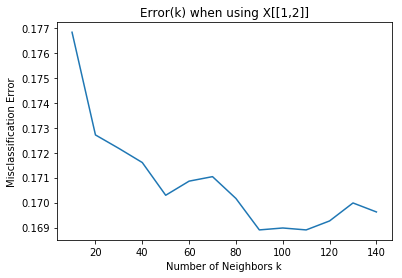

In [390]:
# Get the misclassification error:
msc_firstAttributes = [1-x for x in cv_scores_2d_2]
n_vals_2d = (list(range(10,150,10)))

optimalMSC_2d_2 = n_vals_2d[msc_firstAttributes.index(min(msc_firstAttributes))]

print '\n 2d case: optimal k =', optimalMSC_2d_2

plt.figure()
plt.plot(n_vals_2d,msc_firstAttributes)
plt.title('Error(k) when using X[[1,2]]')
plt.xlabel("Number of Neighbors k")
plt.ylabel("Misclassification Error")
plt.show()

### Let's plot the 2d model

We will use the model based on the first two attributes.

In [391]:
print X2d_train_2.head()

                       1                2
439660   -1.03471923e+00  -5.97857475e-01
1914016   2.51424591e+02   1.54621094e+02
420420    1.45749524e-01  -2.43782178e-01
309868    1.59413166e+01   3.41016121e+01
1598064  -1.05631836e+02   1.04834702e+02


In [393]:
x1_min, x1_max = X2d_train_2[1].astype('float').min() - 1, X2d_train_2[1].astype('float').max() + 1
x2_min, x2_max = X2d_train_2[2].astype('float').min() - 1, X2d_train_2[2].astype('float').max() + 1

In [503]:
h = 1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                         np.arange(x2_min, x2_max, h))

In [505]:
Z = nrnb_2d_firstAttributes.predict(np.c_[xx.ravel(), yy.ravel()])

In [405]:
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

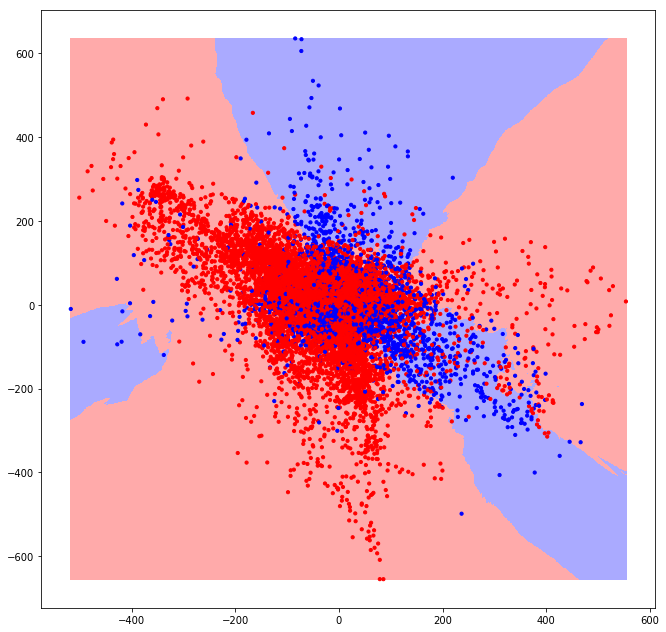

In [516]:
Z = Z.reshape(xx.shape)
plt.figure(figsize=(11,11))
plt.pcolormesh(xx, yy, Z,cmap=cmap_light)

# plotting the training data points
plt.scatter(X2d_train_2[1].astype('float'),X2d_train_2[2].astype('float'),c=y2d_train_2,s=10,cmap=cmap_bold)
plt.show()


In our cross validation step we saw that k ~ neighbors is optimal according the accuracy measure when we working with the X[1],X[2] 2d-model. For comparison, let's generate the above map when using the lower k = 10

In [517]:
nrnb_2d_firstAttributes_k5 = KNeighborsClassifier(n_neighbors=5,weights='uniform').fit(X2d_train_2,y2d_train_2)

In [519]:
Z_k5 = nrnb_2d_firstAttributes_k5.predict(np.c_[xx.ravel(), yy.ravel()])

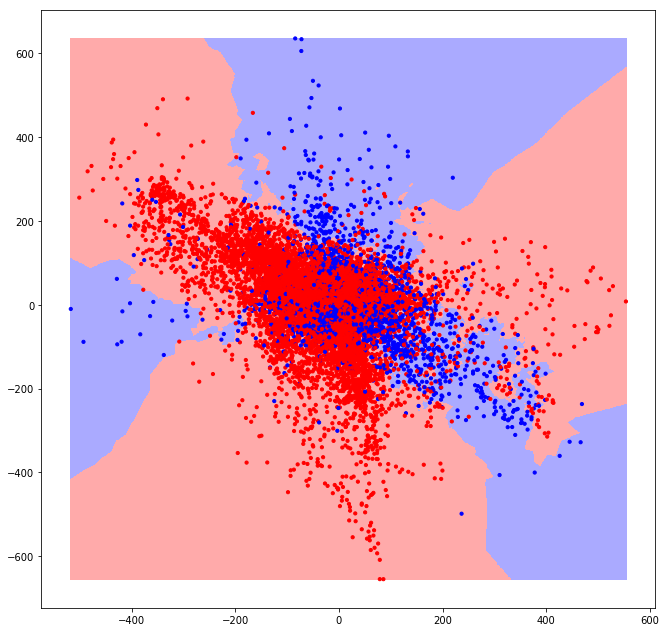

In [520]:
Z_k5 =Z_k5.reshape(xx.shape)

plt.figure(figsize=(11,11))
plt.pcolormesh(xx,yy,Z_k5,cmap=cmap_light)
plt.scatter(X2d_train_2[1].astype('float'),X2d_train_2[2].astype('float'),c=y2d_train_2,s=10,cmap=cmap_bold)
plt.show()

### Can we improve our results if we normalize the input data?

We will see if that in the 2d-dimensional case l2-normalization of each trace is not helpful (actually harmful).

In [39]:
from sklearn.preprocessing import Normalizer

In [50]:
transformer = Normalizer(norm='l2').fit(X2d_train_2)
X2d_train_scaled = transformer.transform(X2d_train_2)
X2d_test_scaled = transformer.transform(X2d_test_2)

In [41]:
X2d_train_2.head()

,1,2
439660,-1.03471923e+00,-5.97857475e-01
1914016,2.51424591e+02,1.54621094e+02
420420,1.45749524e-01,-2.43782178e-01
309868,1.59413166e+01,3.41016121e+01
1598064,-1.05631836e+02,1.04834702e+02


In [48]:
X2d_train_scaled

array([[-0.86585793, -0.50028996],
       [ 0.85181212,  0.52384741],
       [ 0.51314951, -0.85829924],
       ...,
       [-0.84555938, -0.53388139],
       [ 0.16935147,  0.98555572],
       [-0.53483076, -0.8449592 ]])

In [58]:
nrnb_scaled = KNeighborsClassifier(n_neighbors=30,weights='uniform').fit(X2d_train_scaled,y2d_train_2)

In [60]:
print 'After ls-normalizing each observation, we obtain an accuracy of', nrnb_scaled.score(X2d_test_scaled,y2d_test_2)

After ls-normalizing each observation, we obtain an accuracy of 0.7949845679012346
